In [720]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 
import copy
from datetime import datetime, timedelta

# Nueva sección

In [807]:
train_df = pd.read_csv('train.csv')

In [722]:
train_df.dtypes

id                  object
date                object
year_week            int64
product_number       int64
reporterhq_id        int64
prod_category       object
specs                int64
display_size       float64
segment             object
sales_units        float64
inventory_units    float64
dtype: object

In [723]:
train_df.isna().sum()

id                   0
date                 0
year_week            0
product_number       0
reporterhq_id        0
prod_category        0
specs                0
display_size         0
segment              0
sales_units        491
inventory_units    493
dtype: int64

In [808]:
subset = train_df[["id", "reporterhq_id"]]
dup = np.sum(subset.duplicated())
print(f"Existen {dup} columnas duplicadas")

Existen 0 columnas duplicadas


In [809]:
sales_unit_na= train_df["sales_units"].isna().sum()/train_df.shape[0]
inventory_unit_na= train_df["inventory_units"].isna().sum()/train_df.shape[0]

print(f"Un {sales_unit_na*100}% de sales_unit son nulos y {inventory_unit_na*100}% de inventory null")

Un 3.1771709589750223% de sales_unit son nulos y 3.190112592209137% de inventory null


In [810]:
non_na = train_df.dropna()
non_na.isna().sum()

id                 0
date               0
year_week          0
product_number     0
reporterhq_id      0
prod_category      0
specs              0
display_size       0
segment            0
sales_units        0
inventory_units    0
dtype: int64

In [811]:
test = non_na
test = test.groupby("id")[["id", "inventory_units"]].sum()
new_df = non_na.drop_duplicates(subset=['id'],keep = 'first')
test.reset_index(inplace=True)

new_df = pd.merge(new_df, test, on = 'id', how = 'left')
new_df.loc[new_df['inventory_units_y'].notnull(), 'inventory_units'] = new_df['inventory_units_y']
new_df.drop(['inventory_units_y', 'inventory_units_x', 'reporterhq_id'], axis=1, inplace=True)
new_df["date"] = pd.to_datetime(new_df["date"])
new_df.describe()

<ipython-input-811-40e6df7d8e12>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test = test.groupby("id")[["id", "inventory_units"]].sum()


,year_week,product_number,specs,display_size,sales_units,inventory_units
count,7542.000000,7542.000000,7542.000000,7542.000000,7542.000000,7542.000000
mean,202228.855741,126547.873906,110023.623972,15.157704,27.761204,137.733890
std,64.456047,80560.155233,63865.270865,1.422126,29.988587,118.812817
min,201915.000000,6909.000000,967.000000,11.000000,0.000000,0.000000
25%,202210.000000,51324.000000,56086.000000,14.000000,4.000000,55.000000
50%,202232.000000,114492.000000,108304.000000,15.600000,19.000000,111.000000
75%,202252.000000,201348.000000,155687.000000,15.600000,41.000000,186.000000
max,202318.000000,247737.000000,236915.000000,17.300000,186.000000,889.000000


In [812]:
new_df = new_df[new_df.year_week >= 202101]
new_df = new_df.sort_values(by = 'id').reset_index(drop = True)

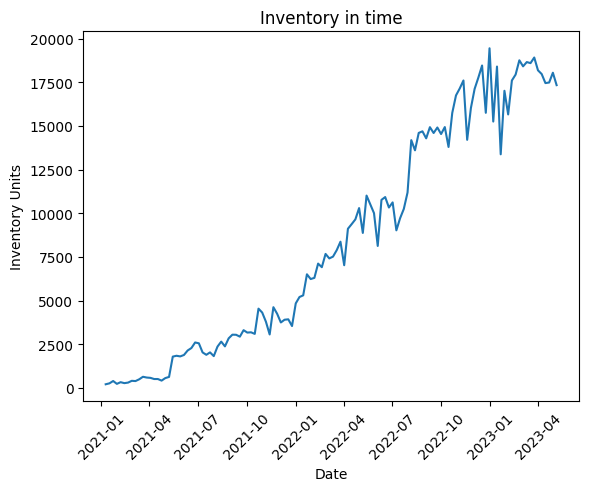

In [729]:
gd = new_df.groupby('date').sum(numeric_only = True)
plt.plot(gd.index, gd.inventory_units)
plt.xticks(rotation = 45)
plt.xlabel('Date') 
plt.ylabel('Inventory Units')
plt.title('Inventory in time')
plt.show()

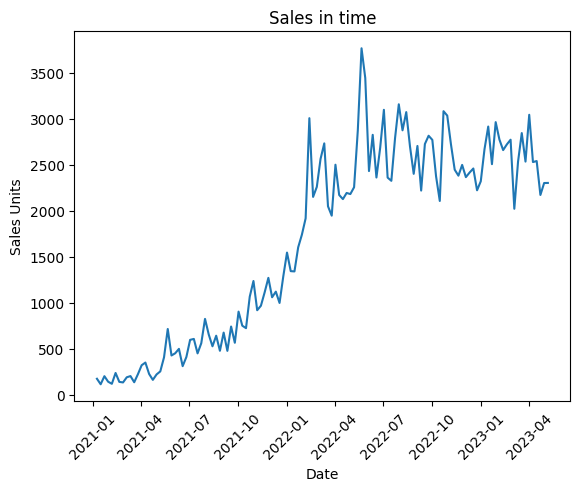

In [730]:
plt.plot(gd.index, gd.sales_units)
plt.xticks(rotation = 45)
plt.xlabel('Date') 
plt.ylabel('Sales Units')
plt.title('Sales in time')
plt.show()

In [731]:
for i,row in new_df[:-1].iterrows():
    date = row["date"]
    product_number = row["product_number"]
    row2 = new_df.iloc[i+1]
    if row2["product_number"] == product_number:
        diff = row2["date"] - date
        if diff.days > 7:
            p_num = row["product_number"]
            weeks_diff = int(diff.days / 7)
            if weeks_diff <= 3:
                incremento = (row2["sales_units"] -  row["sales_units"]) / (weeks_diff)
                current_date = date
                for k in range(1,weeks_diff):
                    new_row = copy.copy(row)
                    current_date += timedelta(days=7)
                    new_row["date"] = current_date
                    new_row["sales_units"] = row["sales_units"] + k * incremento
                    anho, semana, _ = current_date.isocalendar()
                    new_row["identifier"] = str(anho) + str('{:0>2d}'.format(semana)) + "-" + str(row["product_number"])
                    new_df.loc[i+k-1] = new_row

In [732]:
new_df[['sales_units', 'inventory_units', 'year_week']] = new_df[['sales_units', 'inventory_units', 'year_week']].astype(int)

In [733]:
new_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year_week,7370.0,202233.979240,55.306371,202101.0,202211.0,202233.0,202252.0,202318.0
product_number,7370.0,124166.207056,79747.701800,6909.0,48363.0,112518.0,196413.0,247737.0
specs,7370.0,110509.599729,64359.763331,967.0,58020.0,108304.0,156654.0,236915.0
display_size,7370.0,15.137870,1.426134,11.0,14.0,15.6,15.6,17.3
sales_units,7370.0,27.887924,30.059301,0.0,4.0,19.0,42.0,186.0
inventory_units,7370.0,139.592402,118.845188,0.0,57.0,112.0,187.0,889.0


In [813]:
error = []
for i, row in new_df[1:].iterrows():
  if row.sales_units + row.inventory_units < new_df.loc[i-1].inventory_units:
      error.append(new_df.loc[i-1].inventory_units - (row.sales_units + row.inventory_units))
      if new_df.loc[i-1].inventory_units - (row.sales_units + row.inventory_units) < 0:
          print(f"Fila {i} tiene un error con una medida de {new_df.loc[i-1].inventory_units - (row.sales_units + row.inventory_units)}")

print("Numero de errores es ", len(error))
print("Min de errores es ", np.array(error).min())
print("Min de errores es ", np.array(error).max())
print("Media de errores es ", np.array(error).mean())
print("Std de errores es ", np.array(error).std())


Numero de errores es  3004
Min de errores es  1.0
Min de errores es  837.0
Media de errores es  109.04494007989348
Std de errores es  114.55070998246332


In [735]:
new_df["purchases_units"] =  0

for i in range(1, len(new_df)):
    compras = new_df.at[i, 'inventory_units'] - (new_df.at[i, 'sales_units'] + new_df.at[i-1, 'inventory_units'])
    new_df.at[i, 'purchases_units'] = compras
    
new_df.head()
new_df.purchases_units[new_df.purchases_units < 0 ] = 0


<ipython-input-735-f3ee59b97159>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.purchases_units[new_df.purchases_units < 0 ] = 0


In [814]:
date_time = pd.to_datetime(new_df["date"], format='%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
new_df = new_df.drop(["date"], axis = 1)

week = 24*60*60*7
year = 52*week

new_df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
new_df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
new_df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
new_df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


In [815]:
new_df.head()

,id,year_week,product_number,prod_category,specs,display_size,segment,sales_units,inventory_units,Week sin,Week cos,Year sin,Year cos
0,202101-11844,202101,11844,Doraemon,109271,15.6,Gaming,32.0,25.0,0.974928,-0.222521,0.946699,0.32212
1,202101-12831,202101,12831,Doraemon,180829,15.6,Gaming,8.0,50.0,0.974928,-0.222521,0.946699,0.32212
2,202101-233919,202101,233919,Clover,106370,15.6,Core,2.0,0.0,0.974928,-0.222521,0.946699,0.32212
3,202101-235893,202101,235893,Clover,50284,17.3,Core,21.0,44.0,0.974928,-0.222521,0.946699,0.32212
4,202101-247737,202101,247737,Arale,10637,13.3,Premium,43.0,8.0,0.974928,-0.222521,0.946699,0.32212


In [738]:
new_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year_week,7370.0,202233.979240,5.530637e+01,202101.000000,202211.000000,202233.000000,202252.000000,202318.000000
product_number,7370.0,124166.207056,7.974770e+04,6909.000000,48363.000000,112518.000000,196413.000000,247737.000000
specs,7370.0,110509.599729,6.435976e+04,967.000000,58020.000000,108304.000000,156654.000000,236915.000000
display_size,7370.0,15.137870,1.426134e+00,11.000000,14.000000,15.600000,15.600000,17.300000
sales_units,7370.0,27.887924,3.005930e+01,0.000000,4.000000,19.000000,42.000000,186.000000
inventory_units,7370.0,139.592402,1.188452e+02,0.000000,57.000000,112.000000,187.000000,889.000000
purchases_units,7370.0,43.399457,8.890604e+01,0.000000,0.000000,0.000000,50.000000,810.000000
Week sin,7370.0,0.974928,2.335396e-13,0.974928,0.974928,0.974928,0.974928,0.974928
Week cos,7370.0,-0.222521,1.023200e-12,-0.222521,-0.222521,-0.222521,-0.222521,-0.222521
Year sin,7370.0,0.110459,6.934653e-01,-0.999404,-0.539320,0.205660,0.770953,0.999404


## Normalización

In [816]:
train = new_df

train = train.drop(["id"], axis =1)

Y_train = train.inventory_units
X_train = train#.drop("inventory_units", axis = 1)

X_train = pd.get_dummies(X_train, columns=['product_number', 'segment', 'prod_category'])

X_train.dtypes

year_week                   int64
specs                       int64
display_size              float64
sales_units               float64
inventory_units           float64
                           ...   
prod_category_Clover        uint8
prod_category_Conan         uint8
prod_category_Doraemon      uint8
prod_category_Goku          uint8
prod_category_Luffy         uint8
Length: 119, dtype: object

In [819]:
num_columns = ["inventory_units", "year_week", "display_size", "sales_units", "specs"]

sub_X_train = X_train[num_columns]

train_mean = sub_X_train.mean()
train_std = sub_X_train.std()

sub_X_train = (sub_X_train - train_mean) / train_std

X_train[num_columns] = sub_X_train[num_columns]
X_train.describe()

,year_week,specs,display_size,sales_units,inventory_units,Week sin,Week cos,Year sin,Year cos,product_number_6909,...,segment_Core,segment_Gaming,segment_Premium,prod_category_Arale,prod_category_Bobobo,prod_category_Clover,prod_category_Conan,prod_category_Doraemon,prod_category_Goku,prod_category_Luffy
count,7370.000000,7.370000e+03,7.370000e+03,7.370000e+03,7.370000e+03,7.370000e+03,7.370000e+03,7370.000000,7370.000000,7370.000000,...,7370.000000,7370.000000,7370.000000,7370.000000,7370.000000,7370.000000,7370.000000,7370.00000,7370.000000,7370.000000
mean,0.000000,1.542562e-17,1.542562e-17,2.313843e-17,3.085124e-17,9.749279e-01,-2.225209e-01,0.110459,-0.052360,0.013026,...,0.500814,0.247626,0.251560,0.156988,0.028630,0.257666,0.094573,0.14152,0.232293,0.088331
std,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.335396e-13,1.023200e-12,0.693465,0.710138,0.113392,...,0.500033,0.431662,0.433939,0.363814,0.166774,0.437379,0.292644,0.34858,0.422324,0.283795
min,-2.404411,-1.702035e+00,-2.901459e+00,-9.277635e-01,-1.174573e+00,9.749279e-01,-2.225209e-01,-0.999404,-0.999404,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,-0.415490,-8.155655e-01,-7.978702e-01,-7.946933e-01,-6.949579e-01,9.749279e-01,-2.225209e-01,-0.539320,-0.770953,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,-0.017706,-3.426985e-02,3.240441e-01,-2.956797e-01,-2.321710e-01,9.749279e-01,-2.225209e-01,0.205660,-0.086200,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.325835,7.169759e-01,3.240441e-01,4.694745e-01,3.989021e-01,9.749279e-01,-2.225209e-01,0.770953,0.636892,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000
max,1.519188,1.964044e+00,1.516078e+00,5.260005e+00,6.305746e+00,9.749279e-01,-2.225209e-01,0.999404,0.999404,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [820]:
def sliding_window(data, labels, input_width, label_width=1, offset=1):
    x = []
    y = []

    for i in range(len(data)-input_width-label_width-offset):
        _x = data[i:i+input_width]
        _y = labels[i+input_width+offset:i+input_width+offset+label_width]
        x.append(_x)
        y.append(_y)

    x, y = np.array(x),np.array(y)

    if len(x.shape) == 2:
        x = x[:,:,np.newaxis]

    if len(y.shape) == 2:
        y = y[:,:,np.newaxis]
    
    return x, y

In [821]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lm_model = LinearRegression()
lm_model.fit(X_train, Y_train)

y_pred = lm_model.predict(X_train)
y_true = Y_train
rms = mean_squared_error(y_true, y_pred, squared=False)
rms

2.5730883172210053e-13

## Ventanas

In [822]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train, val_df=None, test_df=None,
               label_columns=None):
    # Store the raw data.
    self.train_df = train
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [823]:
w2 = WindowGenerator(input_width=24, label_width=1, shift=1,label_columns=['inventory_units'], train = X_train)
w2

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['inventory_units']

In [824]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [825]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(X_train[:w2.total_window_size]),
                           np.array(X_train[1000:1000+w2.total_window_size]),
                           np.array(X_train[7000:7000+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 25, 119)
Inputs shape: (3, 24, 119)
Labels shape: (3, 1, 1)


### Plot


In [826]:
w2.example = example_inputs, example_labels

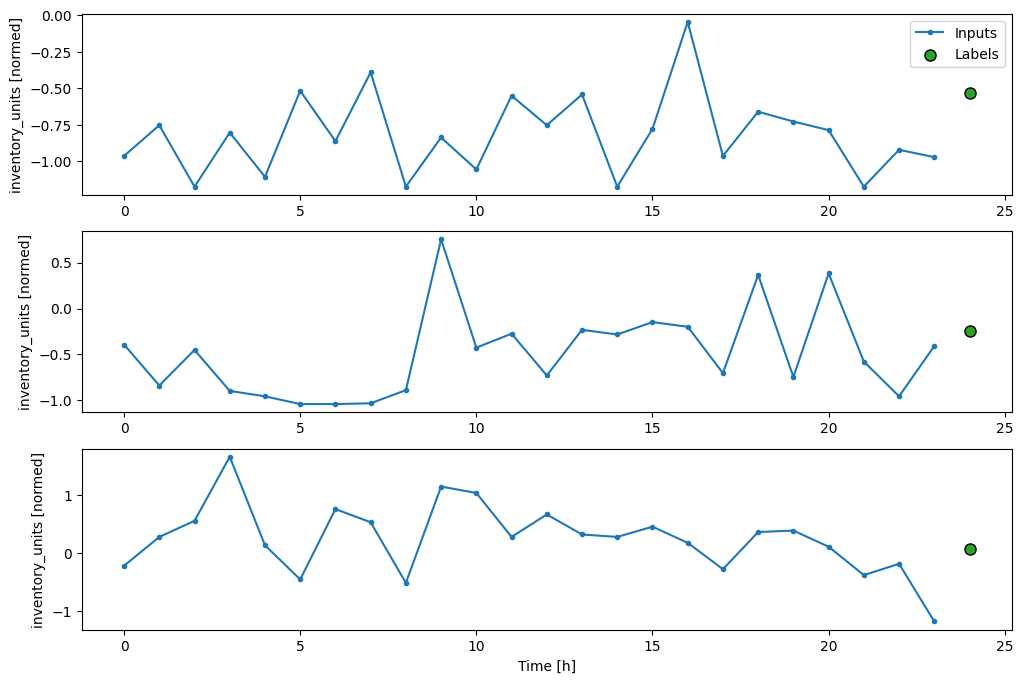

In [827]:
def plot(self, model=None, plot_col='inventory_units', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot
w2.plot()

In [828]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [829]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train

### Baseline


In [830]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=64, return_sequences=True), 
    tf.keras.layers.LSTM(units=32, return_sequences=True), 
    tf.keras.layers.LSTM(units=32, return_sequences=False),
    tf.keras.layers.Dense(units=1)
])

In [831]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      callbacks=[early_stopping])
  return history

In [832]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['inventory_units'], train = X_train)

history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
230/230 [==============================] - 17s 43ms/step - loss: 0.8947 - root_mean_squared_error: 0.9459
Epoch 2/50
230/230 [==============================] - 8s 36ms/step - loss: 0.8896 - root_mean_squared_error: 0.9432
Epoch 3/50
230/230 [==============================] - 10s 42ms/step - loss: 0.8890 - root_mean_squared_error: 0.9429
Epoch 4/50
230/230 [==============================] - 10s 43ms/step - loss: 0.8884 - root_mean_squared_error: 0.9426
Epoch 5/50
230/230 [==============================] - 10s 42ms/step - loss: 0.8882 - root_mean_squared_error: 0.9425
Epoch 6/50
230/230 [==============================] - 8s 36ms/step - loss: 0.8880 - root_mean_squared_error: 0.9424
Epoch 7/50
230/230 [==============================] - 9s 38ms/step - loss: 0.8879 - root_mean_squared_error: 0.9423
Epoch 8/50
230/230 [==============================] - 10s 43ms/step - loss: 0.8879 - root_mean_squared_error: 0.9423
Epoch 9/50
230/230 [==============================] - 10s 42ms/step

KeyboardInterrupt: ignored

In [ ]:
wide_window.train_df

## LTSM

In [ ]:
import tensorflow as tf

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=64, return_sequences=True), 
    tf.keras.layers.LSTM(units=32, return_sequences=True), 
    tf.keras.layers.LSTM(units=32, return_sequences=False),
    tf.keras.layers.Dense(units=1)
])